#  Machine Learning with Membership Privacy using Adversarial Regularization
## Milad Nasr, Reza Shokri, Amir Houmansadr
https://arxiv.org/abs/1807.05852

In [1]:
import sys 
import os
import copy 
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Dataset

sys.path.insert(0, '../Utils')

import models
from train import *
from metrics import *  
from data_downloaders import *

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 2000
batch_size = 128
lr_classification = 0.0001
lr_inference = 0.001
lr_attack = 0.001

## Data loading

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


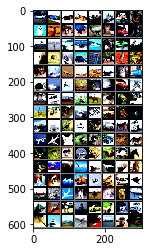

In [3]:
# define series of transforms to pre process images 
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
n_classes = 10

# load training set 
trainset = torchvision.datasets.CIFAR10('../Datasets/', train=True, transform=transform, download=True)
testset = torchvision.datasets.CIFAR10('../Datasets/', train=False, transform=transform, download=True)

total_size = len(trainset)
split = int(total_size * 0.8)
indices = list(range(total_size))

D_idx = indices[:40000]
D_A_idx = indices[:20000]
D_prime_idx = indices[40000:45000]
D_prime_A_idx = indices[45000:]

eval_train = indices[20000:30000]
#eval_out = #testset

D_sampler = SubsetRandomSampler(D_idx)
D_A_sampler = SubsetRandomSampler(D_A_idx)
D_prime_sampler = SubsetRandomSampler(D_prime_idx)
D_prime_A_sampler = SubsetRandomSampler(D_prime_A_idx)
eval_train_sampler = SubsetRandomSampler(eval_train)


D_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=D_sampler, num_workers=1)
D_A_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=D_A_sampler, num_workers=1)
D_prime_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=D_prime_sampler, num_workers=1)
D_prime_A_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=D_prime_A_sampler, num_workers=1)
eval_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=eval_train_sampler, num_workers=1)
eval_out_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)


# load test set 
#testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(D_loader).next()
imshow(torchvision.utils.make_grid(imgs))


## Attack model 

In [4]:
class inference_attack(nn.Module): 
    def __init__(self, n_classes): 
        super(inference_attack, self).__init__()
        
        self.n_classes = n_classes
        
        self.prediction_vector_block = nn.Sequential(
            nn.Linear(n_classes, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Linear(512, 64), 
            nn.ReLU()
        )
        
        self.label_block = nn.Sequential(
            nn.Linear(n_classes, 512), 
            nn.ReLU(), 
            nn.Linear(512, 64), 
            nn.ReLU()
        )
        
        self.common_block = nn.Sequential(
            nn.Linear(128, 256), 
            nn.ReLU(), 
            nn.Linear(256, 64), 
            nn.ReLU(), 
            nn.Linear(64, 1)  
        )
        
    def forward(self, prediction_vector, one_hot_label): 
        prediction_block_out = self.prediction_vector_block(prediction_vector)
        label_block_out = self.label_block(one_hot_label)
        out = F.sigmoid(self.common_block(torch.cat((prediction_block_out, label_block_out), dim=1)))
        return out
    

adversarial_regularization_net = inference_attack(n_classes).to(device)
adversarial_regularization_net.apply(models.weights_init)

adversarial_regularization_loss = nn.BCELoss()
adversarial_regularization_optim = optim.Adam(adversarial_regularization_net.parameters(), lr=lr_inference)

attack_net = inference_attack(n_classes).to(device)
attack_net.apply(models.weights_init)

attack_net2 = copy.deepcopy(attack_net)
attack2_loss = nn.BCELoss()
attack2_optim = optim.Adam(attack_net2.parameters(), lr=lr_attack)

attack_loss = nn.BCELoss()
attack_optim = optim.Adam(attack_net.parameters(), lr=lr_attack)

## Target Model (Classification)

In [5]:
vgg16 = torchvision.models.vgg16(num_classes=n_classes)
# vgg16 fix for cifar10 image size 
vgg16.classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(64, 64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(64, n_classes),
        )

#net = resnet18.to(device)
target_net = vgg16.to(device)
target_net.apply(models.weights_init)
target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr_classification)


undefended_net = copy.deepcopy(target_net)
undefended_loss = nn.CrossEntropyLoss()
undefended_optim = optim.Adam(undefended_net.parameters(), lr=lr_classification)

#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)


## Helper functions

In [6]:
def label_to_onehot(labels, num_classes=10): 
    one_hot = torch.eye(num_classes)
    return one_hot[labels]

## Training functions

In [7]:
def adversarial_train(inference_net, classification_net, train_set, out_set, test_set, 
                      infer_optim, infer_loss, class_optim, class_loss, n_epochs, k, privacy_theta, verbose=False):
    losses = []

    inference_net.train()
    classification_net.train()
    
    for epoch in range(n_epochs):

        train_top = np.array([])
        out_top = np.array([])
        
        train_p = np.array([])
        out_p = np.array([])
        
        total_inference = 0
        total_correct_inference = 0
        
        inference_losses = np.array([])
        classification_losses = np.array([])
        
        for k_count in range(k): 
            # train inference network 
            train_imgs, train_lbls = iter(train_set).next()
            train_imgs, train_lbls = train_imgs.to(device), train_lbls.to(device)
            out_imgs, out_lbls = iter(out_set).next()
            out_imgs, out_lbls = out_imgs.to(device), out_lbls.to(device)
            
            mini_batch_size = train_imgs.shape[0]
            
            train_lbl = torch.ones(mini_batch_size).to(device)
            out_lbl = torch.zeros(mini_batch_size).to(device)
            
            train_posteriors = F.softmax(classification_net(train_imgs), dim=1)
            out_posteriors = F.softmax(classification_net(out_imgs), dim=1)
            
            '''
            t_p = train_posteriors.cpu().detach().numpy().flatten()
            o_p = out_posteriors.cpu().detach().numpy().flatten()
            
            train_p = np.concatenate((train_p, t_p))
            out_p = np.concatenate((out_p, o_p))
            '''
            
            train_sort, _ = torch.sort(train_posteriors, descending=True)
            out_sort, _ = torch.sort(out_posteriors, descending=True)

            t_p = train_sort[:,:4].cpu().detach().numpy().flatten()
            o_p = out_sort[:,:4].cpu().detach().numpy().flatten()
            
            train_p = np.concatenate((train_p, t_p))
            out_p = np.concatenate((out_p, o_p))
                    
            train_top = np.concatenate((train_top, train_sort[:,0].cpu().detach().numpy()))
            out_top = np.concatenate((out_top, out_sort[:,0].cpu().detach().numpy()))
            
            infer_optim.zero_grad()

            train_inference = torch.squeeze(inference_net(train_posteriors, label_to_onehot(train_lbls).to(device)))
            out_inference = torch.squeeze(inference_net(out_posteriors, label_to_onehot(out_lbls).to(device)))
            
            total_inference += 2*mini_batch_size
            total_correct_inference += torch.sum(train_inference > 0.5).item() + torch.sum(out_inference < 0.5).item()
            
            loss_train = infer_loss(train_inference, train_lbl)
            loss_out = infer_loss(out_inference, out_lbl)
            
            loss = privacy_theta * (loss_train + loss_out) / 2 
            loss.backward()
            
            infer_optim.step()
            
        # train classifiction network 
        train_imgs, train_lbls = iter(train_set).next()
        train_imgs, train_lbls = train_imgs.to(device), train_lbls.to(device)
        
        class_optim.zero_grad()

        outputs = classification_net(train_imgs)
        train_posteriors = F.softmax(outputs, dim=1)

        loss_classification = class_loss(outputs, train_lbls)
        train_lbl = torch.ones(mini_batch_size).to(device)
        
        train_inference = torch.squeeze(inference_net(train_posteriors, label_to_onehot(train_lbls).to(device)))
        loss_infer = infer_loss(train_inference, train_lbl)
        loss = loss_classification - privacy_theta * loss_infer
        
        loss.backward()
        class_optim.step()
        
        '''
        correct += (train_predictions>=0.5).sum().item()
        correct += (out_predictions<0.5).sum().item()
        total += train_predictions.size(0) + out_predictions.size(0)
        print("[%d/%d][%d/%d] loss = %.2f, accuracy = %.2f" % (epoch, n_epochs, i, len(shadow_train), loss.item(), 100 * correct / total))
        '''        
        
        if epoch % 20 == 0 and epoch != 0 and verbose: 

            plt.figure()
            sns.distplot(train_p,label='maximum train posterior')
            sns.distplot(out_p,label='maximum out posterior')
            #sns.distplot(train_top,label='maximum train posterior')
            #sns.distplot(out_top,label='maximum out posterior')
            plt.legend()
            plt.show()

            inference_accuracy = 100 * (total_correct_inference / total_inference)
            classification_accuracy = eval_target_net(classification_net, test_set, classes=classes)
            print("[%d/%d] Inference accuracy = %.2f%%, Classification accuracy = %.2f%%" % (epoch, n_epochs, inference_accuracy, classification_accuracy))
                  
        
def train_attacker(attack_net, target_net, attack_train, attack_out, optimizer, criterion, n_epochs, verbose=False):
    losses = []

    target_net.eval()
    attack_net.train()
    for epoch in range(n_epochs):
       
        total = 0
        correct = 0

        train_top = np.empty((0,2))
        out_top = np.empty((0,2))
        for i, ((train_imgs, train_lbls), (out_imgs, out_lbls)) in enumerate(zip(attack_train, attack_out)):

            if train_imgs.shape[0] != out_imgs.shape[0]: 
                continue
            mini_batch_size = train_imgs.shape[0]
            train_imgs, train_lbls = train_imgs.to(device), train_lbls.to(device)
            out_imgs, out_lbls = out_imgs.to(device), out_lbls.to(device)

            train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)

            out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)

            optimizer.zero_grad()

            train_sort, _ = torch.sort(train_posteriors, descending=True)
            train_top_k = train_sort.clone().to(device)

            out_sort, _ = torch.sort(out_posteriors, descending=True)
            out_top_k = out_sort.clone().to(device)

            train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
            out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))

            train_lbl = torch.ones(mini_batch_size).to(device)
            out_lbl = torch.zeros(mini_batch_size).to(device)
            
            train_inference = torch.squeeze(attack_net(train_posteriors, label_to_onehot(train_lbls).to(device)))
            out_inference = torch.squeeze(attack_net(out_posteriors, label_to_onehot(out_lbls).to(device)))
            
            loss_train = criterion(train_inference, train_lbl)
            loss_out = criterion(out_inference, out_lbl)
            loss = (loss_train + loss_out) / 2
            loss.backward()
            optimizer.step()
            
            correct += (train_inference>=0.5).sum().item()
            correct += (out_inference<0.5).sum().item()
            total += train_inference.size(0) + out_inference.size(0)

            if verbose: 
                print("[%d/%d][%d/%d] loss = %.2f, accuracy = %.2f" % (epoch, n_epochs, i, len(attack_train), loss.item(), 100 * correct / total))


## Evaluation functions

In [8]:
def eval_attacker(attack_net, target_net, attack_train, attack_out):

    target_net.eval()
    attack_net.eval()
       
    total = 0
    correct = 0

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for i, ((train_imgs, train_lbls), (out_imgs, out_lbls)) in enumerate(zip(attack_train, attack_out)):
        mini_batch_size = train_imgs.shape[0]
        train_imgs, train_lbls = train_imgs.to(device), train_lbls.to(device)
        out_imgs, out_lbls = out_imgs.to(device), out_lbls.to(device)

        train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)
        out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)

        train_inference = torch.squeeze(attack_net(train_posteriors, label_to_onehot(train_lbls).to(device)))
        out_inference = torch.squeeze(attack_net(out_posteriors, label_to_onehot(out_lbls).to(device)))

        true_positives += (train_inference >= 0.5).sum().item()
        false_positives += (out_inference >= 0.5).sum().item()
        false_negatives += (train_inference < 0.5).sum().item()
        
        correct += (train_inference>=0.5).sum().item()
        correct += (out_inference<0.5).sum().item()
        total += train_inference.size(0) + out_inference.size(0)

    accuracy = 100 * correct / total 
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives !=0 else 0
    print("accuracy = %.2f, precision = %.2f, recall = %.2f" % (accuracy, precision, recall))
    
    return accuracy 


## Results

Attack performance on Adversarial Regularization Defense Network: 
accuracy = 54.68, precision = 0.53, recall = 0.78

Attack performance on normal network: 
accuracy = 65.97, precision = 0.60, recall = 0.95


Adversarial Regularization network classification accuracy on training set: 

Accuracy = 81.12 %



Adversarial Regularization network classification accuracy on test set: 

Accuracy = 68.42 %



Normal network classification accuracy on training set: 

Accuracy = 98.91 %



Normal network classification accuracy on test set: 

Accuracy = 74.12 %


## Train with varying privacy lambda

In [ ]:
# tuples of (lambda, attack_accuracy, classification_train_accuracy, classification_test_accuracy)
adv_reg_metrics = []


for lambd in [0, 1, 2, 3, 10]: 
    adversarial_regularization_net = inference_attack(n_classes).to(device)
    adversarial_regularization_net.apply(models.weights_init)

    adversarial_regularization_loss = nn.BCELoss()
    adversarial_regularization_optim = optim.Adam(adversarial_regularization_net.parameters(), lr=lr_inference)
    
    vgg16 = torchvision.models.vgg16(num_classes=n_classes)
    # vgg16 fix for cifar10 image size 
    vgg16.classifier = nn.Sequential(
                nn.Linear(512, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, n_classes),
            )

    #net = resnet18.to(device)
    target_net = vgg16.to(device)
    target_net.apply(models.weights_init)
    target_loss = nn.CrossEntropyLoss()
    target_optim = optim.Adam(target_net.parameters(), lr=lr_classification)
    
    adversarial_train(adversarial_regularization_net, target_net, D_loader, D_prime_loader, eval_out_loader,
                  adversarial_regularization_optim, adversarial_regularization_loss, target_optim, 
                  target_loss, n_epochs, 7, lambd)
    
    attack_net = inference_attack(n_classes).to(device)
    attack_net.apply(models.weights_init)

    attack_loss = nn.BCELoss()
    attack_optim = optim.Adam(attack_net.parameters(), lr=lr_attack)
    
    train_attacker(attack_net, target_net, D_A_loader, D_prime_A_loader, attack_optim, attack_loss, 20)
    
    print("\nAttack performance on Adversarial Regularization Defense Network: ")
    attack_accuracy = eval_attacker(attack_net, target_net, eval_train_loader, eval_out_loader)
    
    
    print("\nAdversarial Regularization network classification accuracy on training set: ")
    train_accuracy = eval_target_net(target_net, D_loader, classes=None)

    print("\nAdversarial Regularization network classification accuracy on test set: ")
    test_accuracy = eval_target_net(target_net, eval_out_loader, classes=None)

    adv_reg_metrics.append((lambd,attack_accuracy, train_accuracy, test_accuracy))
    
    torch.save(target_net.state_dict(), './adv_reg_net_%d.pth' % lambd)
    

print(adv_reg_metrics)

## Train with L2 regularization 

In [ ]:
# tuples of (l2_factor, attack_accuracy, classification_train_accuracy, classification_test_accuracy)
l2_reg_metrics = []


for l2 in [0, 0.001, 0.005, 0.01]: 
    
    vgg16 = torchvision.models.vgg16(num_classes=n_classes)
    # vgg16 fix for cifar10 image size 
    vgg16.classifier = nn.Sequential(
                nn.Linear(512, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, 64),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(64, n_classes),
            )

    target_net = vgg16.to(device)
    target_net.apply(models.weights_init)
    target_loss = nn.CrossEntropyLoss()
    target_optim = optim.Adam(target_net.parameters(), lr=lr_classification, weight_decay=l2)
    
    
    train(target_net, D_loader, eval_out_loader, target_optim, target_loss, 
          n_epochs=100, classes=None, verbose=False)
    
    attack_net = inference_attack(n_classes).to(device)
    attack_net.apply(models.weights_init)

    attack_loss = nn.BCELoss()
    attack_optim = optim.Adam(attack_net.parameters(), lr=lr_attack)
    
    train_attacker(attack_net, target_net, D_A_loader, D_prime_A_loader, attack_optim, attack_loss, 20)
    
    print("\nAttack performance on L2 regularized Network: ")
    attack_accuracy = eval_attacker(attack_net, target_net, eval_train_loader, eval_out_loader)
    
    
    print("\nL2 regularized network classification accuracy on training set: ")
    train_accuracy = eval_target_net(target_net, D_loader, classes=None)

    print("\nL2 regularized network classification accuracy on test set: ")
    test_accuracy = eval_target_net(target_net, eval_out_loader, classes=None)

    l2_reg_metrics.append((l2,attack_accuracy, train_accuracy, test_accuracy))
    
    torch.save(target_net.state_dict(), './l2_reg_net_%.3f.pth' % l2)
print(l2_reg_metrics)

In [ ]:
'''
# Base run 


# Training with adversarial regularization 
adversarial_train(adversarial_regularization_net, target_net, D_loader, D_prime_loader, eval_out_loader,
                  adversarial_regularization_optim, adversarial_regularization_loss, target_optim, 
                  target_loss, n_epochs, 7, 1)

# Normal training 
train(undefended_net, D_loader, eval_out_loader, undefended_optim, undefended_loss, n_epochs=100, classes=None, verbose=True)

# Train attack networks 
train_attacker(attack_net, target_net, D_A_loader, D_prime_A_loader, attack_optim, attack_loss, 20)
train_attacker(attack_net2, undefended_net, D_A_loader, D_prime_A_loader, attack2_optim, attack2_loss, 20)

# Attack results 

print("\nAttack performance on Adversarial Regularization Defense Network: ")
eval_attacker(attack_net, target_net, eval_train_loader, eval_out_loader)

print("\nAttack performance on normal network: ")
eval_attacker(attack_net2, undefended_net, eval_train_loader, eval_out_loader)


# Classification results 

print("\nAdversarial Regularization network classification accuracy on training set: ")
train_accuracy = eval_target_net(target_net, D_loader, classes=None)

print("\nAdversarial Regularization network classification accuracy on test set: ")
test_accuracy = eval_target_net(target_net, eval_out_loader, classes=None)

print("\nNormal network classification accuracy on training set: ")
train_accuracy = eval_target_net(undefended_net, D_loader, classes=None)

print("\nNormal network classification accuracy on test set: ")
test_accuracy = eval_target_net(undefended_net, eval_out_loader, classes=None)
'''